<a href="https://colab.research.google.com/github/bhardwajshivam/MSFT_stockpred/blob/main/MSFT_stock_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of `MSFT, Inc.` stock values

Time series analysis refers to the analysis of change in the trend of the data over a period of time. Time series analysis has a variety of applications. One such application is the prediction of the future value of an item based on its past values.  
We will demonstrate time series analysis with the help of an LSTM network. We will be predicting the future stock prices of the Apple Company (AAPL), based on its stock prices of the past 7 years.

In [ ]:
!pip install tensorflow

For various manipulations we will need Numpy and will plot the results using matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

I am just curious whether my GPU card is still visible, so let me do the following.

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15618903036600876886
xla_global_id: -1
]


The above will work on Google Colab as well, provided you change the runtime and select GPU.

As a data set we will fetch a long string of stock values for a company at Yahoo Finance. For example https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch .
You adjust the start date and the end data of the report and then download the dataset. Fot training data we selected the period between January 4th 2016 to August 31st, 2023. Downloaded data is stored in the file AAPL.csv
To test the predictive power of LSTM, we will use the Apple stock prices from the first day of September till October 20th, 2023. So, in order to evaluate the performance of the algorithm, as the test data, create a separate file with Apple's stock prices between September 1st and October 20th, 2023.  

Downloaded data are loaded in a panda. Besides the date index, downloaded data have 6 features: Open,	High,	Low,	Close,	Adj Close, and	Volume.
    At the moment, we do not care about all of those features. We will look only at the opening price and ignore the others.

In [ ]:
msft_training_complete = pd.read_csv(r'MSFT.csv')

In [ ]:
msft_training_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1923,2023-08-24,332.850006,332.980011,319.959991,319.970001,319.970001,23281400
1924,2023-08-25,321.470001,325.359985,318.799988,322.980011,322.980011,21684100
1925,2023-08-28,325.660004,326.149994,321.720001,323.700012,323.700012,14808500
1926,2023-08-29,321.880005,328.980011,321.880005,328.410004,328.410004,19284600
1927,2023-08-30,328.670013,329.809998,326.450012,328.790009,328.790009,15222100


<Axes: xlabel='Date'>

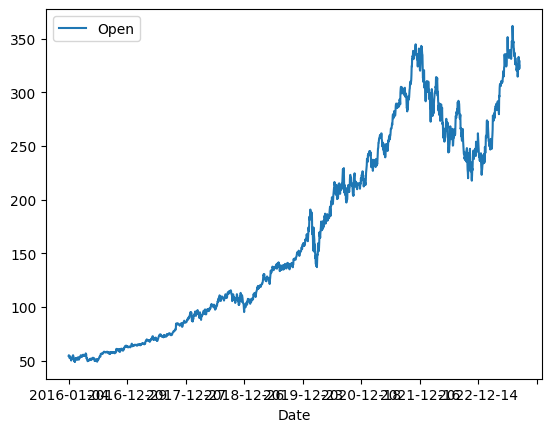

In [ ]:
msft_training_complete.plot(x='Date',y='Open')

In [ ]:
msft_training_processed = msft_training_complete.iloc[:, 1:2].values

In [ ]:
print(msft_training_processed)
print("length of the dataset: ", msft_training_processed.size)

[[ 54.32    ]
 [ 54.93    ]
 [ 54.32    ]
 ...
 [325.660004]
 [321.880005]
 [328.670013]]
length of the dataset:  1928


We want to normilize our data and will use SciKitLearn `MinMaxScaler` from sklearn.preprocessing libary. All values of `Open`(ing) price will be scaled to the interval between 0 and 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

msft_training_scaled = scaler.fit_transform(msft_training_processed)


In a time series problem, we usually predict a value at time T, based on the data from the previous N time steps. In our case, we will predict `Open` price on day T, based on `Open` prices on days T-1,T-2,..., T-N. The number of steps (days), N, could be arbitray. Concretely, we will predict the opening stock price of the data based on the opening stock prices for the past 30 days. One presumes that larger N will give higher prediction. However, larger N will most probably result in longer training and possibly some loss of numerical precision.

In [ ]:
print(msft_training_scaled.shape)
print(msft_training_scaled)

(1928, 1)
[[0.01801514]
 [0.01996359]
 [0.01801514]
 ...
 [0.88472228]
 [0.87264831]
 [0.89433677]]


In the script below we create two lists: feature_set and labels. There are 1928 records in the training data. We execute a loop that starts from 61st record and stores 60 records at the beginning to the feature_set list. The 61st record is stored in the labels list. Then we move the cursor by one point and repeate the mapping.

In [ ]:
features_set = []
labels = []
for i in range(60, 1928):
    features_set.append(msft_training_scaled[i-60:i,0])
    labels.append(msft_training_scaled[i,0])

In [ ]:
print(len(features_set))
print(len(labels))
print(len(features_set[0]))
#print(features_set)
print(labels[0])

1868
1868
60
0.020027473089085507


We need to convert both the `feature_set` and the `labels list` to numpy arrays before we could use them for training. Execute the following code:

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)

What are the dimensions of the feature set?

In [ ]:
print(features_set.shape)
print(features_set.shape[0], features_set.shape[1])

(1868, 60)
1868 60


In [ ]:
print(labels.shape)
print(labels)

(1868,)
[0.02002747 0.02034688 0.02156067 ... 0.88472228 0.87264831 0.89433677]


## Convert Training Data to Right Shape
In order to train LSTM, we need to convert our data into the shape accepted by the LSTM.
LSTM expects a three-dimensional format.
The first dimension is the number of records or rows in the dataset which is 1868 in our case.
The second dimension is the number of time steps which is 60.
The last dimension is the number of indicators. Since we are only using one feature, i.e Open, the number of indicators will be 1. Execute the following:

In [ ]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [ ]:
print(features_set.shape)

(1868, 60, 1)


## Traning the LSTM
We will use Keras API.  
The LSTM model we will create is sequential model with multiple layers. We will use four LSTM layers followed by a dense layer that predicts the future stock price.
Let's first import the libraries that we will need in order to create our model:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

## Building the Model

As a first step, we need to instantiate the Sequential class. This is our model class. We will add LSTM, Dropout and Dense layers to this model. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter is `return_sequences`, which is set to `True` since we will add more layers to the model. The first parameter to the `input_shape` is the number of time steps while the last parameter is the number of indicators.

`return_sequences`=`True`: `Boolean`. Whether to return the last output in the output sequence, or the full sequence. That return sequences return the hidden state output for each input time step. When stacking LSTM layers you must set `return_sequnce` to `True`
We are leaving
`unroll=False`: `Boolean` (default `False`). If `True`, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1),unroll=False))

To avoid over-fitting, we will add Dropout layers after every LSTM layer.

In [ ]:
model.add(Dropout(0.2))

In [ ]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))


The number of neurons, units = 50, in every LSTM subcell is somewhat arbitrary. You should play with that parameter and find an optimal value

## Creating a Dense Layer

To make our model more robust, we add a Dense layer at the end of the model. The number of neurons in the Dense layer will be set to 1 since we want to predict a single value in the output.


In [ ]:
model.add(Dense(units = 1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Model Compilation
Finally, we need to compile our LSTM model before we can train it on the training data.

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Model Training
Now is the time to train the model that we defined in the previous few steps. To do so, we call the `fit` method on the model and pass it our training features and labels as shown below:


In [ ]:
history = model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
59/59 [==============================] - 18s 172ms/step - loss: 0.0223
Epoch 2/100
59/59 [==============================] - 8s 140ms/step - loss: 0.0039
Epoch 3/100
59/59 [==============================] - 6s 105ms/step - loss: 0.0039
Epoch 4/100
59/59 [==============================] - 7s 124ms/step - loss: 0.0034
Epoch 5/100
59/59 [==============================] - 6s 106ms/step - loss: 0.0036
Epoch 6/100
59/59 [==============================] - 7s 125ms/step - loss: 0.0028
Epoch 7/100
59/59 [==============================] - 6s 106ms/step - loss: 0.0035
Epoch 8/100
59/59 [==============================] - 7s 124ms/step - loss: 0.0027
Epoch 9/100
59/59 [==============================] - 6s 106ms/step - loss: 0.0028
Epoch 10/100
59/59 [==============================] - 7s 125ms/step - loss: 0.0026
Epoch 11/100
59/59 [==============================] - 7s 116ms/step - loss: 0.0025
Epoch 12/100
59/59 [==============================] - 7s 115ms/step - loss: 0.0025
Epoch 13/100

In [ ]:
from tensorflow.keras.models import load_model
model.save('msft.h5')
#model = load_model('apple.h5')
history_dict = history.history
history_dict.keys()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss'])

From the above, we see that our model history contains information only on the training loss. Had we had validation data passed to the training process we would have had validation loss and perhaps accuracy available as well.

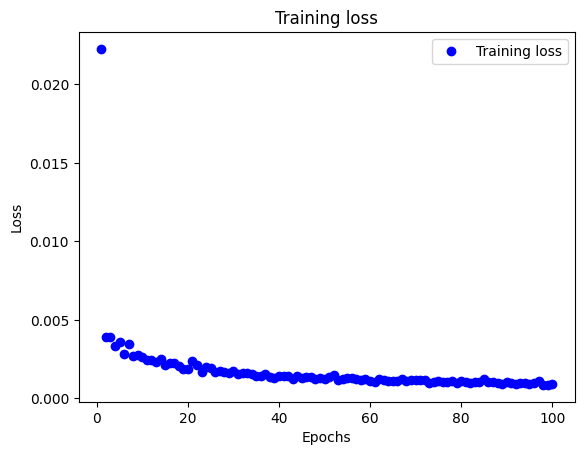

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Testing our LSTM
We have successfully trained our LSTM, now we will test the performance of our network on the test set containing the opening stock prices for the month of September and a part of October 2023.

As we did with the training data, we need to convert our test data to the right format. We first import our test data. The test data contain only prices for 34 days and has no overlap with the training data.

Execute the following:


In [ ]:
msft_testing_complete = pd.read_csv(r'MSFT_test.csv')
msft_testing_processed = msft_testing_complete.iloc[0:34, 1:2].values
msft_testing_processed
print("Number of data points in test data: ", msft_testing_processed.size)

Number of data points in test data:  34


## Converting Test Data to Right Format

For each day in the test set, we want our feature set to contain the opening stock prices for the previous 60 days, what is almost 3 months. To do so, we need to concatenate our training data and test data before preprocessing. Execute the following:


In [ ]:
msft_total = pd.concat((msft_training_complete['Open'], msft_testing_complete['Open']), axis=0)

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 34 test days and stock prices from the last 60 days from the training set. Execute the following code to fetch those 94 values.

In [ ]:
test_inputs = msft_total[len(msft_total) - len(msft_testing_complete) - 60:].values

In [ ]:
print(test_inputs.shape)
print(len(test_inputs))
print(test_inputs)

(100,)
100
[335.329987 331.649994 323.940002 324.98999  328.579987 334.470001
 334.339996 337.480011 351.320007 339.309998 336.369995 334.119995
 334.359985 333.720001 331.859985 334.660004 334.709991 337.75
 339.190002 335.089996 337.299988 339.320007 334.600006 331.059998
 336.600006 339.559998 347.589996 345.679993 345.829987 361.75
 353.570007 349.149994 345.850006 347.109985 341.440002 340.480011
 333.670013 336.920013 335.190002 333.630005 326.       331.880005
 328.369995 326.959991 326.470001 326.019989 320.26001  321.390015
 323.       320.799988 320.540009 314.48999  317.929993 325.5
 323.820007 332.850006 321.470001 325.660004 321.880005 328.670013
 329.       333.380005 331.290009 330.089996 337.23999  335.820007
 331.309998 339.149994 336.920013 327.799988 326.170013 329.51001
 319.26001  321.320007 316.589996 315.130005 312.299988 310.98999
 317.75     316.279999 320.829987 314.029999 319.089996 316.549988
 324.75     330.959991 331.209991 330.570007 332.380005 331.049988

As we did for the training set, we need to scale our test data. We will use already defined `scalar` object. Execute the following:

In [ ]:
test_inputs = test_inputs.reshape(-1,1)
print(test_inputs.shape)
test_inputs = scaler.transform(test_inputs)
print(test_inputs)

(100, 1)
[[0.91560989]
 [0.90385535]
 [0.87922829]
 [0.88258214]
 [0.89404921]
 [0.91286294]
 [0.91244768]
 [0.92247744]
 [0.96668479]
 [0.92832273]
 [0.91893185]
 [0.91174496]
 [0.91251153]
 [0.91046731]
 [0.9045261 ]
 [0.91346984]
 [0.91362951]
 [0.92333983]
 [0.92793944]
 [0.91484331]
 [0.92190241]
 [0.9283547 ]
 [0.9132782 ]
 [0.9019708 ]
 [0.91966655]
 [0.92912128]
 [0.95477049]
 [0.9486696 ]
 [0.94914871]
 [1.        ]
 [0.97387168]
 [0.95975339]
 [0.94921266]
 [0.95323725]
 [0.93512634]
 [0.93205996]
 [0.91030764]
 [0.92068871]
 [0.91516275]
 [0.91017985]
 [0.88580829]
 [0.90459004]
 [0.89337846]
 [0.88887466]
 [0.88730955]
 [0.88587213]
 [0.86747376]
 [0.87108319]
 [0.87622576]
 [0.86919854]
 [0.86836813]
 [0.84904331]
 [0.86003128]
 [0.8842112 ]
 [0.87884501]
 [0.9076884 ]
 [0.87133868]
 [0.88472228]
 [0.87264831]
 [0.89433677]
 [0.89539081]
 [0.9093813 ]
 [0.90270549]
 [0.89887244]
 [0.92171077]
 [0.9171751 ]
 [0.90276934]
 [0.92781165]
 [0.92068871]
 [0.89155776]
 [0.8863513

We scaled our data, now let's prepare our final test input set that will contain previous 60 stock prices from the training_set. Execute the following:

In [ ]:
test_features = []
for i in range(60, 94):
    test_features.append(test_inputs[i-60:i, 0])


Finally, we need to convert our data into the three-dimensional format which can be used as input to the LSTM. Execute the following code

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
print(test_features.shape)

(34, 60, 1)


## Making Predictions
We preprocessed our test data and now we can use it to make predictions. To do so, we simply need to call the `predict()` method on the model that we trained. Execute the following


In [ ]:
predictions = model.predict(test_features)

2/2 [==============================] - 0s 37ms/step


Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we use the `ìnverse_transform` method of the `scaler` object we created during training. This is accomplished with the following:

In [ ]:
predictions = scaler.inverse_transform(predictions)

Finally, let's see how well did our algorithm predicted the future stock prices. On the same diagram we will present original Open prices in the test data (blue) and predictions in red.

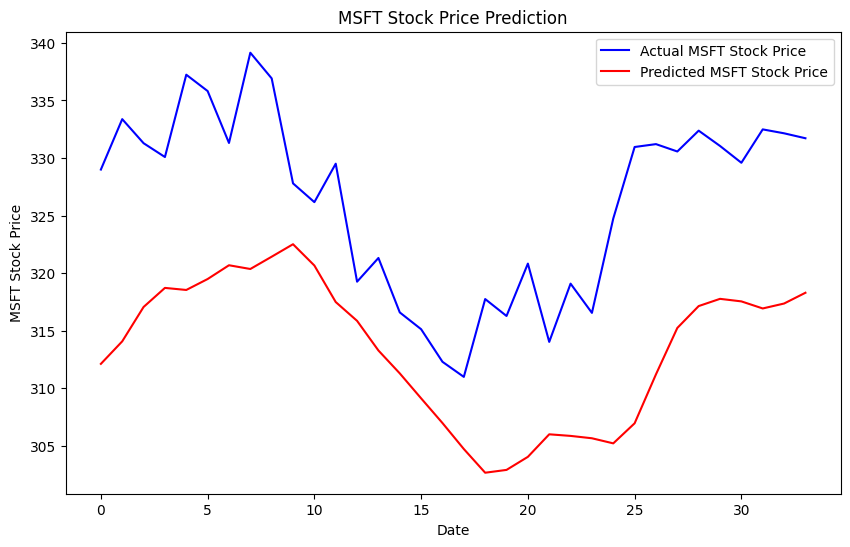

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(msft_testing_processed, color='blue', label='Actual MSFT Stock Price')
plt.plot(predictions , color='red', label='Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()
